In [18]:
import os
import re
from string import punctuation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm, naive_bayes
from sklearn.metrics import ConfusionMatrixDisplay
import torch
from torch import nn

# Классификация программ политических партий

## Чтение данных

В данной работе используются программы политических партий из англоязычных стран, собранные в рамках проекта [Manifesto](https://manifesto-project.wzb.eu/).
В качестве исходных данных используются:
* датасет с информацией о всех политических программах (`MAIN_DATASET`), в т.ч., различные метрики, которые и будут использоваться для разбиения всех программ на классы;
* датасет с информацией о всех политических партиях (`PARTY_DATASET`);
* набор текстов политических программ партий (434 шт.).

In [19]:
ROOT_PATH = os.path.split(os.getcwd())[0]
DATA_DIR = os.path.join(ROOT_PATH, 'data')
MAIN_DATASET = os.path.join(DATA_DIR, 'MPDataset_MPDS2021a.csv')
PARTY_DATASET = os.path.join(DATA_DIR, 'parties_MPDataset_MPDS2021a.csv')
RAW_DIR = os.path.join(DATA_DIR, 'raw')

In [20]:
df_main = pd.read_csv(MAIN_DATASET)
df_main.sample(5)

,country,countryname,oecdmember,eumember,edate,date,party,partyname,partyabbrev,parfam,...,per608_3,per703_1,per703_2,rile,planeco,markeco,welfare,intpeace,datasetversion,id_perm
72,11,Sweden,10,0,18/09/1988,198809,11220,Left Communists Party,VPK,20,...,NaN,NaN,NaN,-37.400,7.400,1.300,16.100,6.100,2021a,DAW5CC
3483,80,Bulgaria,0,20,25/06/2005,200506,80813,Bulgarian People's Union,BNS,80,...,NaN,NaN,NaN,-1.422,3.791,5.213,18.957,0.000,2021a,Y1OZWL
53,11,Sweden,10,0,19/09/1976,197609,11620,Moderate Coalition Party,MSP,60,...,NaN,NaN,NaN,2.200,1.900,12.600,15.500,1.900,2021a,6VJYHS
931,21,Belgium,10,10,18/05/2003,200305,21421,Flemish Liberals and Democrats,VLD,40,...,NaN,NaN,NaN,0.373,10.075,2.612,13.806,2.239,2021a,31Q184
4258,94,Russia,0,0,17/12/1995,199512,94427,Russia’s Democratic Choice – United Democrats,DVR-OD,40,...,NaN,NaN,NaN,-1.014,4.665,5.882,17.241,7.708,2021a,BSJEY1


In [21]:
df_parties = pd.read_csv(PARTY_DATASET)
df_parties.sample(5)

,country,countryname,party,abbrev,name,name_english,year_min,year_max,is_alliance,max_pervote,max_presvote
872,90,Moldova,90320,BMD,Blocul electoral ‘Moldova Democrată',Electoral Bloc ‘Democratic Moldova',2005,2005,1,28.525,NaN
242,33,Spain,33908,BNG,Bloque Nacionalista Galego,Galician Nationalist Bloc,1996,2019,0,1.321,NaN
743,84,Georgia,84716,ENM,Ertiani Natsionaluri Modzraoba,United National Movement,2003,2016,1,67.750,NaN
252,34,Greece,34210,KKE,Kommounistiko Komma Elladas,Communist Party of Greece,1974,2015,0,10.938,NaN
654,81,Croatia,81953,IDS,Istarski demokratski sabor,Istrian Democratic Assembly,1992,2007,0,2.352,NaN


Все тексты программ изначально располагались в отдельных файлах, названия которых состояли из значений столбцов `party` и `date` для этой программы в основном датасете. Также эти файлы были сгруппированы по странам. Соберем все тексты в один `DataFrame`, куда также поместим метрики этих программ: `rile` (right-left), `planeco`, `markeco`, `welfare` и `intpeace` (смысл понятен из названий).

In [22]:
texts = []
text_ids = []
data = []
COLUMNS = ('rile', 'planeco', 'markeco', 'welfare', 'intpeace')

for country in os.listdir(RAW_DIR):
    cur_path = os.path.join(RAW_DIR, country)

    # iterate over documents
    for fname in os.listdir(cur_path):
        if not fname.endswith('.csv'):
            continue
        df = pd.read_csv(
            os.path.join(cur_path, fname),
            quotechar='"',
            encoding='utf-8'
        )
        text = ' '.join(df['text'])
        texts.append(text)

        # find entry in the main dataset
        party, date = map(int, fname[:-4].split('_'))
        row = df_main[(df_main['date'] == date) &
                      (df_main['party'] == party)]
        assert row.shape[0] == 1
        text_ids.append(row['id_perm'].values[0])
        metrics = [row[col].values[0] for col in COLUMNS]
        data.append(metrics)


df_texts = pd.DataFrame(columns=COLUMNS, data=data)
df_texts['id'] = text_ids
df_texts.set_index('id', inplace=True)
df_texts['text'] = texts
df_texts.head()

,rile,planeco,markeco,welfare,intpeace,text
id,,,,,,
16R91Q,3.537,0.723,4.502,6.190,0.000,It’s people that really matter. “Our ability ...
91HRS8,-30.722,11.089,1.119,14.344,0.712,Labour election policy 1969. Towards nationhoo...
7HJL9O,-7.228,1.098,2.745,11.711,0.366,ECONOMY & INFRASTRUCTURE POLICY ACC New Zealan...
6AFU6O,36.327,1.224,23.265,8.163,0.000,Health ACT BELIEVES Rising government expendit...
YEB6QU,-17.325,3.571,2.242,15.236,3.571,AGRICULTURE STRENGTH IN FARMING Despite the ...


## Кластеризация

Т.к. в домашнем задании требовалось сделать не регрессию, а классификация, то выполним кластеризацию всех прочитанных программ с помощью метрик и метода `KMeans`.
Для наглядности составим `DataFrame` из центров полученных кластеров, куда также поместим общее число вошедших в класс программ.

In [23]:
RESCALE = True
N_CLUSTERS = 4

# get metrics from manifesto dataframe
X = np.array(df_texts.loc[:, COLUMNS])
if RESCALE:
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

# classify X with kmeans
model = KMeans(n_clusters=N_CLUSTERS, init='k-means++')
df_texts['cluster'] = model.fit_predict(X)
centers = model.cluster_centers_
if RESCALE:
    centers = scaler.inverse_transform(centers)

# construct DataFrame of cluster centers
df_clusters = pd.DataFrame(data=centers, columns=COLUMNS)
counts = [(df_texts['cluster'] == i).sum() for i in range(N_CLUSTERS)]
df_clusters['count'] = counts

df_clusters

,rile,planeco,markeco,welfare,intpeace,count
0,-19.784547,8.980787,2.654827,13.731213,3.549067,75
1,-20.394752,3.529431,1.544339,24.377009,0.861734,109
2,29.265831,1.368847,15.992136,6.185136,0.536864,59
3,2.148974,2.769131,3.294351,9.501026,1.067141,191


Полученные классы выглядят вполне разумно, посмотрим, программы каких партий вошли в каждый.

In [24]:
for cluster in range(N_CLUSTERS):
    print(f'Cluster #{cluster}')
    counts = {}
    mask = df_texts['cluster'] == cluster
    for id in df_texts.index[mask]:
        row = df_main[df_main['id_perm'] == id]
        assert row.shape[0] == 1
        party_id = row['party'].values[0]
        row = df_parties[df_parties['party'] == party_id]
        assert row.shape[0] == 1
        party_name = row['name_english'].values[0]
        country = row['countryname'].values[0]
        name = country + ': ' + party_name
        counts[name] = counts.get(name, 0) + 1

    for name in sorted(counts.keys()):
        print(f'{name} - {counts[name]} manifesto(s)')
    print()

Cluster #0
Australia: Australian Greens - 1 manifesto(s)
Australia: Australian Labor Party - 3 manifesto(s)
Australia: Centre Alliance - 1 manifesto(s)
Canada: New Democratic Party - 10 manifesto(s)
Canada: Progressive Conservative Party - 1 manifesto(s)
Ireland: Family of the Irish - 6 manifesto(s)
Ireland: Green Party - 1 manifesto(s)
Ireland: Labour Party - 7 manifesto(s)
Ireland: Progressive Democrats - 1 manifesto(s)
Ireland: Soldiers of Destiny - 1 manifesto(s)
Ireland: We Ourselves - 1 manifesto(s)
New Zealand: New Zealand Democratic Party - 6 manifesto(s)
New Zealand: New Zealand Labour Party - 9 manifesto(s)
New Zealand: New Zealand National Party - 1 manifesto(s)
United Kingdom: Conservative Party - 1 manifesto(s)
United Kingdom: Labour Party - 9 manifesto(s)
United Kingdom: Liberal Party - 5 manifesto(s)
United Kingdom: Scottish National Party - 2 manifesto(s)
United Kingdom: Social Democratic Party - 1 manifesto(s)
United States: Democratic Party - 8 manifesto(s)

Cluster #

В `DataFame` с текстами программ был добавлен столбец с номерами классов:

In [25]:
df_texts.sample(5)

,rile,planeco,markeco,welfare,intpeace,text,cluster
id,,,,,,,
QIQY37,-29.400,2.500,5.700,9.800,3.300,Social Credit presents an adequate and realist...,3
1KE1LP,-37.430,0.279,0.000,36.872,1.676,WORKERS UNITE GENERAL ELECTION MANIFESTO THE...,1
5JAHXH,30.415,2.853,4.669,2.529,2.529,"Preamble Abraham Lincoln, our first Republican...",3
Z6VGUO,-30.189,11.321,0.000,3.774,20.755,THE WAY FORWARD NATIONAL ECONOMIC PLAN 1983-1...,0
Y46E7P,8.482,3.571,4.018,4.464,0.000,FIVE KEY ISSUES -1- LOBBY GROUPS The Palmer Un...,3


## Предобработка и векторизация текстов

Сначала выполним простую обработку текстов -- переведём их в нижний регистр, удалим числа и знаки препинания, а также лишние пробельные символы.

In [26]:
for i, row in df_texts.iterrows():
    s = row['text']
    s = s.lower()
    s = re.sub(r'[0-9]+(?:\.[0-9]+)?', '', s)
    for ch in punctuation:
        s = s.replace(ch, '')
    s = re.sub(r'\s+', ' ', s)
    df_texts.loc[i, 'text'] = s

Далее векторизуем тексты с помощью `tf-idf` и разобъём полученный датасет на тренировочный и тестовый.

In [27]:
ENCODING = 'utf-8'
VOCAB_SIZE = 2048

vectorizer = TfidfVectorizer(encoding=ENCODING, max_features=VOCAB_SIZE, stop_words='english')
X = vectorizer.fit_transform(df_texts['text'])
y = np.array(df_texts['cluster'], dtype='uint8')
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=True, test_size=40, stratify=y, random_state=42)

print(f'X_train.shape = {X_train.shape}')
print('Выборка слов из словаря tf-idf:')
print(np.random.choice(vectorizer.get_feature_names_out(), size=20))

X_train.shape = (394, 2048)
Выборка слов из словаря tf-idf:
['fairly' 'conservative' 'hospitals' 'court' 'regulatory' 'fuels' 'fuels'
 'leading' 'representation' 'officials' 'housing' 'savings' 'ground'
 'growth' 'integrated' 'stimulate' 'circumstances' 'servants' 'research'
 'wages']


## Классификация

Сначала попробуем ненейросетевые методы -- наивный байесовский классификатор и SVM.

Accuracy = 0.475


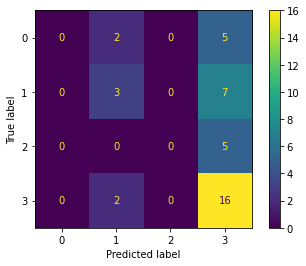

In [28]:
model = naive_bayes.MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'Accuracy = {(y_pred == y_test).sum() / len(y_test)}')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

0.575


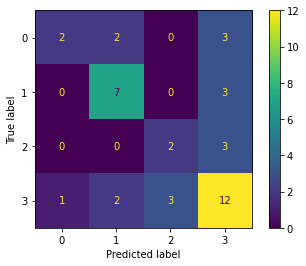

In [29]:
model = svm.LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print((y_pred == y_test).sum() / len(y_test))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

Далее попробуем выполнить классификацию с помощью нейросети. Для начала определим класс, позволяющий более удобно работать с данными.

In [30]:
class Dataset:
    def __init__(self, X: np.ndarray, y: np.ndarray, batch_size: int = 64):
        self.X = X
        self.y = y
        self.num_samples, self.num_features = X.shape
        self.batch_size = batch_size
        self.inds = np.arange(self.num_samples)

    def __len__(self):
        return self.num_samples

    def set_batch_size(self, batch_size: int):
        self.batch_size = batch_size

    def shuffle(self):
        self.inds = np.random.permutation(self.num_samples)

    def __iter__(self):
        if self.batch_size is None:
            return self.X[self.inds], self.y[self.inds]
        start = 0
        while start < len(self):
            stop = min(start + self.batch_size, self.num_samples)
            inds = self.inds[start:stop]
            yield self.X[inds], self.y[inds]
            start = stop

Как показали эксперименты показали, при данной постановке задачи достаточно перцептрона -- т.е. единственного слоя нейросети. Введение дополнительных слоёв приводило только к проблемам с переобучением.

In [31]:
class Perceptron(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.stack = nn.Sequential(
            nn.Linear(num_features, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.stack(x)

Обучим нашу модель.

In [32]:
BATCH_SIZE = 50
LEARNING_RATE = 2e-3
EPOCHS = 600

train_dataset = Dataset(X_train.todense(), y_train, batch_size=BATCH_SIZE)
TRAIN_SIZE = X_train.shape[0]
NUM_CLASSES = len(np.unique(y_train))

# choose device and initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Perceptron(
    num_features=X_train.shape[1],
    num_classes=NUM_CLASSES
)
model = model.to(device)

# train the model
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_losses = np.zeros(EPOCHS)
train_acc = np.zeros_like(train_losses)
test_losses = np.zeros_like(train_losses)
test_acc = np.zeros_like(train_losses)
loss_function = nn.NLLLoss()
if not isinstance(X_test, torch.Tensor):
    X_test = torch.tensor(X_test.todense(), dtype=torch.float32, device=device)
    y_test = torch.tensor(y_test, dtype=torch.uint8, device=device)

for i in range(EPOCHS):

    # train loop
    mean_loss = 0.0
    true_count = 0
    for X_j, y_j in train_dataset:
        X_j = torch.tensor(X_j, dtype=torch.float32, device=device)
        y_j = torch.tensor(y_j, dtype=torch.int64, device=device)
        y_pred = model.forward(X_j)
        loss = loss_function(y_pred, y_j)
        mean_loss += loss.item() * X_j.shape[0] / TRAIN_SIZE
        predictions = torch.argmax(y_pred, axis=1)
        true_count += (predictions == y_j).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_dataset.shuffle()
    train_losses[i] = mean_loss
    train_acc[i] = true_count / TRAIN_SIZE

    # test / validation
    with torch.no_grad():
        y_pred = model.forward(X_test)
        test_losses[i] = loss_function(y_pred, y_test).item()
        pred = torch.argmax(y_pred, axis=1)
        test_acc[i] = (pred == y_test).sum() / len(y_test)

    # display progress
    print('\rEpoch {:4d}, train loss = {:.3f}, test loss = {:.3f}'.format(
            i + 1, train_losses[i], test_losses[i]
            ), end='')

print('\nComplete')

Epoch  600, train loss = 0.062, test loss = 0.957
Complete


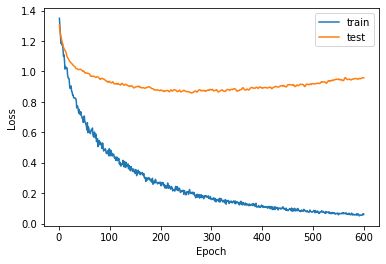

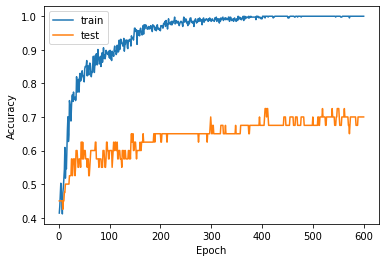

In [33]:
# plot results
epochs = np.arange(1, EPOCHS + 1)
plt.figure()
plt.plot(epochs, train_losses, label='train')
plt.plot(epochs, test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.figure()
plt.plot(epochs, train_acc, label='train')
plt.plot(epochs, test_acc, label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

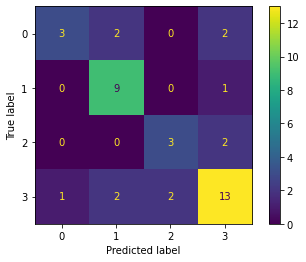

In [34]:
pred = np.argmax(y_pred.cpu().numpy(), axis=1)

ConfusionMatrixDisplay.from_predictions(y_test.cpu().numpy(), pred)

Видно, что нейросеть показала достаточно неплохой результат, опередив более "классические" методы.